In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T

%matplotlib inline

In [2]:
from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
)

In [3]:
def OH(x, l):
    x = torch.LongTensor([[x]])
    one_hot = torch.FloatTensor(1,l)
    return one_hot.zero_().scatter_(1,x,1)

100%|██████████| 2000/2000 [00:15<00:00, 126.13it/s]



Successful episodes: 0.4835


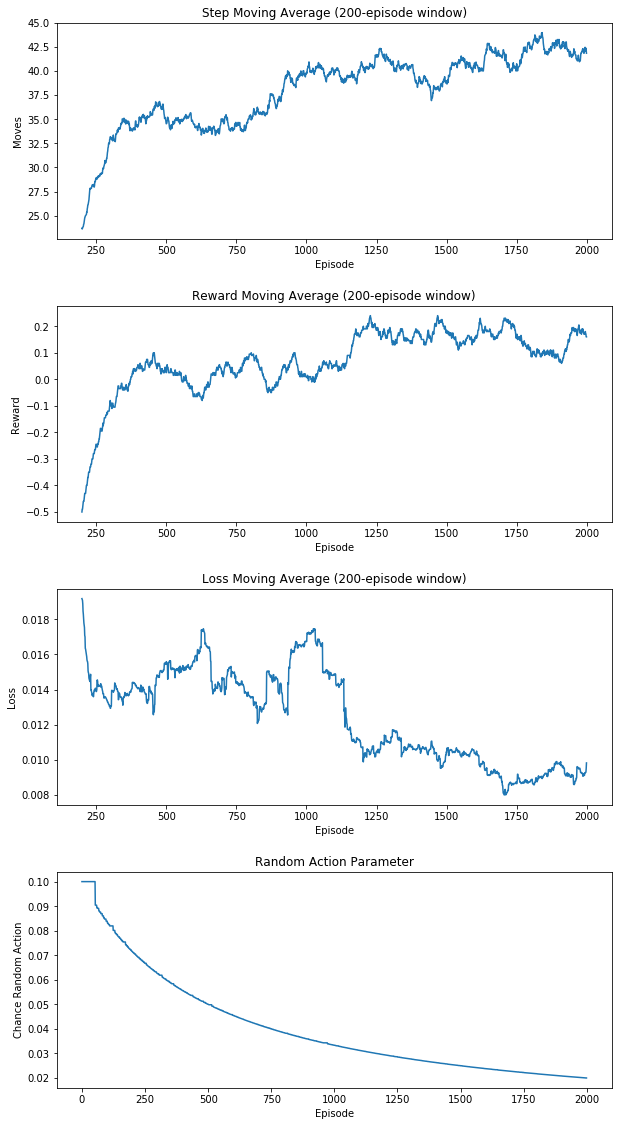

In [4]:
#env = gym.make('FrozenLakeNotSlippery-v0')
env = gym.make('FrozenLake-v0')

# Chance of random action
e = 0.1
learning_rate = 0.01
# Discount Rate
gamma = 0.99
# Training Episodes
episodes = 2000
# Max Steps per episode
steps = 99


# Initialize history memory
step_list = []
reward_list = []
loss_list = []
e_list = []

state_space = env.observation_space.n
action_space = env.action_space.n

model = nn.Sequential(nn.Linear(state_space, action_space, bias=False))
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for i in trange(episodes):
    state = int(env.reset())
    reward_all = 0
    done = False
    s = 0
    l = 0
    
    for s in range(steps):
        if np.random.rand(1) < e:
            state = Variable(OH(state,state_space))
            Q = model(state)
            action = env.action_space.sample()
        else:
            state = Variable(OH(state,state_space))
            Q = model(state)
            _, action = torch.max(Q,1)
            action = action.data[0]
        new_state, reward, done, _ = env.step(action)
        
        if done and reward == 0.0: reward = -1
        
        Q1 = model(Variable(OH(new_state, state_space)))
        maxQ1, _ = torch.max(Q1.data, 1)
        maxQ1 = torch.FloatTensor(maxQ1)
        
        targetQ = Variable(Q.data, requires_grad=False)
        targetQ[0,action] = reward + torch.mul(maxQ1, gamma)
        
        output = model(state)
        train_loss = loss(output, targetQ)
        l+=train_loss.data[0]
        
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        reward_all += reward
        state = new_state
        
        if done == True:
            if reward > 0:
                e = 1./((i/50)+10)
            break
    loss_list.append(l/s)
    step_list.append(s)
    reward_list.append(reward_all)
    e_list.append(e)
    
print('\nSuccessful episodes: {}'.format(np.sum(np.array(reward_list)>0.0)/episodes))

window = int(episodes/10)

plt.figure(figsize=[9,16])
plt.subplot(411)
plt.plot(pd.Series(step_list).rolling(window).mean())
plt.title('Step Moving Average ({}-episode window)'.format(window))
plt.ylabel('Moves')
plt.xlabel('Episode')

plt.subplot(412)
plt.plot(pd.Series(reward_list).rolling(window).mean())
plt.title('Reward Moving Average ({}-episode window)'.format(window))
plt.ylabel('Reward')
plt.xlabel('Episode')

plt.subplot(413)
plt.plot(pd.Series(loss_list).rolling(window).mean())
plt.title('Loss Moving Average ({}-episode window)'.format(window))
plt.ylabel('Loss')
plt.xlabel('Episode')

plt.subplot(414)
plt.plot(e_list)
plt.title('Random Action Parameter')
plt.ylabel('Chance Random Action')
plt.xlabel('Episode')

plt.tight_layout(pad=2)
plt.show()